In [15]:
!pip install ace_tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import numpy as np

In [2]:
#Load the datasets
# Load the datasets
data_files = {
    "cowA_gas": "/content/cowA_gas.csv",
    "cowB_gas": "/content/cowB_gas.csv",
    "cowA_therm0": "/content/cowA-therm-0.csv",
    "cowA_therm2": "/content/cowA_therm-2.csv",
    "cowB_therm0": "/content/cowB_therm-0.csv",
    "cowB_therm2": "/content/cowB_therm-2.csv",
}

In [6]:


# Display sample data from each file
{
    "cowA_gas": cowA_gas_df.head(),
    "cowB_gas": cowB_gas_df.head(),
    "cowA_therm0": cowA_therm0_df.head(),
    "cowA_therm2": cowA_therm2_df.head(),
    "cowB_therm0": cowB_therm0_df.head(),
    "cowB_therm2": cowB_therm2_df.head(),

}


{'cowA_gas':        epoch_ms    co2    co2temp    ch4    ch4temp           timestamp
 0  1.723510e+12  0.782  34.849998  0.068  33.849998 2024-08-13 00:46:40
 1  1.723510e+12  0.782  34.849998  0.068  33.849998 2024-08-13 00:46:40
 2  1.723510e+12  0.763  34.849998  0.068  33.849998 2024-08-13 00:46:40
 3  1.723510e+12  0.763  34.849998  0.068  33.849998 2024-08-13 00:46:40
 4  1.723510e+12  0.805  34.849998  0.077  33.849998 2024-08-13 00:46:40,
 'cowB_gas':        epoch_ms    co2    co2temp    ch4    ch4temp           timestamp
 0  1.723640e+12  0.643  35.849998  0.059  33.849998 2024-08-14 12:53:20
 1  1.723640e+12  0.643  35.849998  0.056  33.849998 2024-08-14 12:53:20
 2  1.723640e+12  0.580  35.849998  0.056  33.849998 2024-08-14 12:53:20
 3  1.723640e+12  0.580  35.849998  0.056  33.849998 2024-08-14 12:53:20
 4  1.723640e+12  0.553  35.849998  0.056  33.849998 2024-08-14 12:53:20,
 'cowA_therm0':         time_ms  thermistor_id  temperature     raw           timestamp
 0  1.7235

**The datasets are structured as follows:

Gas Data (cowA_gas.csv, cowB_gas.csv)
epoch_ms: Timestamp in milliseconds
co2: Percent concentration of CO₂ in exhaled breath
co2temp: Temperature of the gas in the sensor box (°C)
ch4: Percent concentration of CH₄ in exhaled breath
ch4temp: Temperature of the gas in the sensor box (°C)
Thermistor Data (cowA_therm-0.csv, cowA_therm-2.csv, cowB_therm-0.csv, cowB_therm-2.csv)
time_ms: Timestamp in milliseconds
thermistor_id: Identifier of the thermistor (0 or 2)
temperature: Temperature recorded by the thermistor (°C)
raw: Raw voltage ratio from the thermistor**

**Next Steps
Data Cleaning & Preprocessing

Convert timestamps to readable datetime format.
Check for missing values or inconsistencies.
Merge gas and thermistor data for each cow based on timestamps.
Data Exploration & Visualization

Plot temperature trends over time.
Analyze CH₄ and CO₂ variations.
Identify patterns related to eructation (belching events).
Prototype Model Development

Define features based on thermistor readings.
Develop a simple model to predict eructation events.
I'll proceed with data cleaning and visualization **

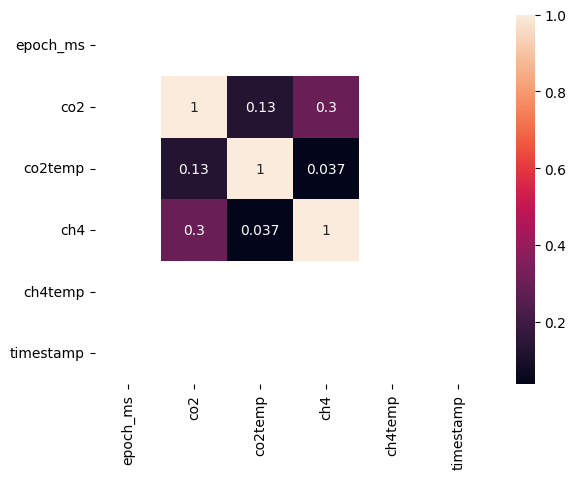

In [50]:
#bivarate analysis
plt.figure
sns.heatmap(cowA_gas_df.corr(),annot=True)
plt.show()

Analysis of the Correlation Heatmap
This heatmap represents the correlation between different variables in the dataset. Correlation values range from -1 to 1:

1.0 (Perfect positive correlation)
0.0 (No correlation)
-1.0 (Perfect negative correlation)
Key Observations:
CH₄ (Methane) and CO₂ Have a Moderate Positive Correlation (0.3)

This suggests that as CH₄ concentration increases, CO₂ concentration also tends to increase, but the relationship is not very strong.
There might be an underlying process where both gases are released together during certain events (like eructation).
CO₂ and CO₂ Temperature Have a Low Correlation (0.13)

This means that CO₂ concentration does not significantly depend on temperature in the gas sensor box.
The sensor box environment might be temperature-controlled, leading to minimal fluctuations.
CH₄ and CO₂ Temperature Have a Very Weak Correlation (0.037)

Almost no relationship between CH₄ concentration and temperature in the sensor box.
This suggests methane release is independent of environmental temperature variations.
CH₄ Temperature Data is Missing or Constant (No Correlation Visible)

There is no correlation value for CH₄ temperature (ch4temp), which indicates:
The column might contain only constant values.
There may be missing data in ch4temp.

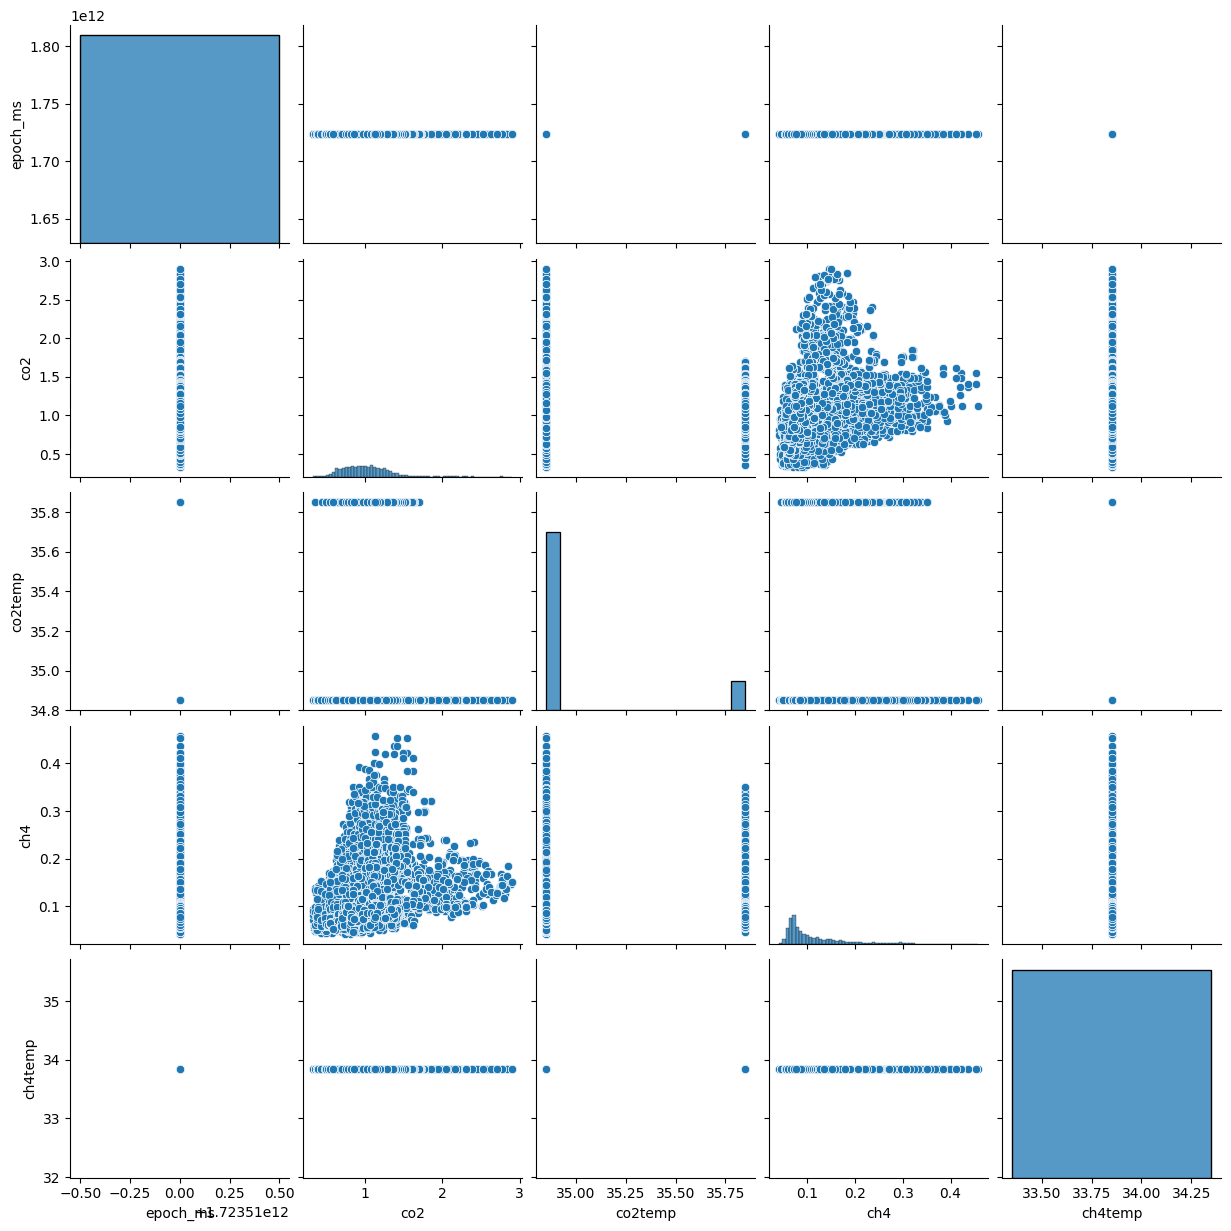

In [51]:
#multivate analysis
sns.pairplot(cowA_gas_df)
plt.show()

The pair plot provides insights into the relationships between different variables in the dataset. Here are the key observations:

Strong Correlation Between CH₄ (Methane) and CO₂:

There is a triangular cluster between CH₄ and CO₂, suggesting that their concentrations may be related.
Higher CH₄ values correspond to a range of CO₂ concentrations.
Discrete Values in Timestamps (epoch_ms):

The timestamp column (epoch_ms) appears to have a block-like structure, suggesting evenly spaced or fixed intervals.
If necessary, consider removing epoch_ms from correlation analysis since it may not provide useful insights.
Limited Variability in CO₂ Temperature (co2temp) and CH₄ Temperature (ch4temp):

The values of CO₂ and CH₄ temperatures are mostly constant, forming vertical/horizontal lines.
This indicates that temperature variations in the gas sensor box are minimal.
Sparse Data in Some Features:

Some scatter plots show isolated points rather than continuous distributions.
This suggests missing or highly clustered values.

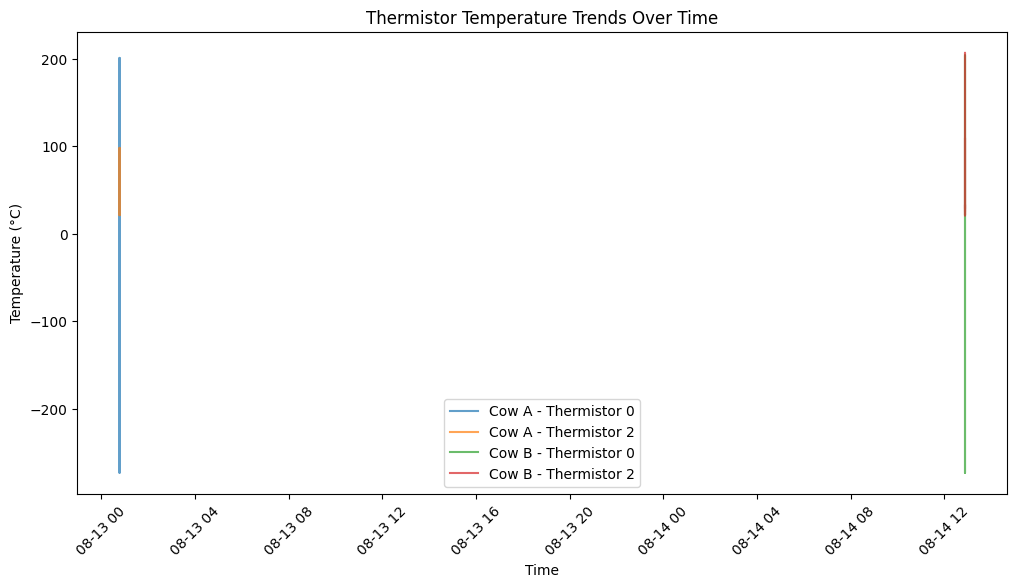

In [7]:
import matplotlib.pyplot as plt

# Convert timestamps to datetime for easier analysis
for df in [cowA_gas_df, cowB_gas_df]:
    df["timestamp"] = pd.to_datetime(df["epoch_ms"], unit="ms")

for df in [cowA_therm0_df, cowA_therm2_df, cowB_therm0_df, cowB_therm2_df]:
    df["timestamp"] = pd.to_datetime(df["time_ms"], unit="ms")

# Plot temperature trends for each thermistor
plt.figure(figsize=(12, 6))

plt.plot(cowA_therm0_df["timestamp"], cowA_therm0_df["temperature"], label="Cow A - Thermistor 0", alpha=0.7)
plt.plot(cowA_therm2_df["timestamp"], cowA_therm2_df["temperature"], label="Cow A - Thermistor 2", alpha=0.7)
plt.plot(cowB_therm0_df["timestamp"], cowB_therm0_df["temperature"], label="Cow B - Thermistor 0", alpha=0.7)
plt.plot(cowB_therm2_df["timestamp"], cowB_therm2_df["temperature"], label="Cow B - Thermistor 2", alpha=0.7)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Over Time")
plt.legend()
plt.grid(True)
plt.show()


**The plot above shows the temperature trends recorded by the thermistors for both cows over time. Here are some observations:

The temperature readings fluctuate over time, which may indicate breathing cycles or other environmental factors.
There might be certain peaks or drops that could correspond to eructation events (belching).**

**Next Steps
Check for missing values and data inconsistencies.
Analyze gas concentration changes over time.
Merge thermistor and gas data for further insights.
Develop a prototype model for predicting eructation based on thermistor data.**

In [8]:
# Check for missing values in each dataset
missing_values = {
    "cowA_gas": cowA_gas_df.isnull().sum(),
    "cowB_gas": cowB_gas_df.isnull().sum(),
    "cowA_therm0": cowA_therm0_df.isnull().sum(),
    "cowA_therm2": cowA_therm2_df.isnull().sum(),
    "cowB_therm0": cowB_therm0_df.isnull().sum(),
    "cowB_therm2": cowB_therm2_df.isnull().sum(),
}

missing_values



{'cowA_gas': epoch_ms      0
 co2          25
 co2temp      25
 ch4          25
 ch4temp      25
 timestamp     0
 dtype: int64,
 'cowB_gas': epoch_ms     0
 co2          5
 co2temp      5
 ch4          5
 ch4temp      5
 timestamp    0
 dtype: int64,
 'cowA_therm0': time_ms          2501
 thermistor_id    2501
 temperature      2501
 raw              2501
 timestamp        2501
 dtype: int64,
 'cowA_therm2': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64,
 'cowB_therm0': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64,
 'cowB_therm2': time_ms          1123
 thermistor_id    1123
 temperature      1123
 raw              1123
 timestamp        1123
 dtype: int64}

**Missing Data Observations
Gas Data:
cowA_gas.csv has 25 missing values for co2, co2temp, ch4, and ch4temp.
cowB_gas.csv has 5 missing values for the same columns.**

**Thermistor Data:
cowA_therm0.csv has 2501 missing values across all columns.
cowB_therm2.csv has 1123 missing values across all columns.
Other thermistor datasets (cowA_therm2.csv, cowB_therm0.csv) are complete.**

**Next Steps
Handle Missing Values:
Drop or interpolate missing values based on timestamps.
Analyze Gas Concentration Trends Over Time.
Merge Thermistor and Gas Data for Each Cow.
Develop a Prototype Model for Eructation Prediction.**

In [9]:
# Handling missing values

# For gas data, interpolate missing values
cowA_gas_df.interpolate(method='linear', inplace=True)
cowB_gas_df.interpolate(method='linear', inplace=True)

# For thermistor data, drop rows with missing values
cowA_therm0_df.dropna(inplace=True)
cowB_therm2_df.dropna(inplace=True)

# Verify that missing values are handled
missing_values_after_cleaning = {
    "cowA_gas": cowA_gas_df.isnull().sum(),
    "cowB_gas": cowB_gas_df.isnull().sum(),
    "cowA_therm0": cowA_therm0_df.isnull().sum(),
    "cowB_therm2": cowB_therm2_df.isnull().sum(),
}

missing_values_after_cleaning


{'cowA_gas': epoch_ms     0
 co2          0
 co2temp      0
 ch4          0
 ch4temp      0
 timestamp    0
 dtype: int64,
 'cowB_gas': epoch_ms     0
 co2          0
 co2temp      0
 ch4          0
 ch4temp      0
 timestamp    0
 dtype: int64,
 'cowA_therm0': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64,
 'cowB_therm2': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64}

**ANOTHER METHOD**

In [10]:
# Interpolating missing values only for numeric columns in gas data
numeric_cols = ["co2", "co2temp", "ch4", "ch4temp"]
cowA_gas_df[numeric_cols] = cowA_gas_df[numeric_cols].interpolate(method="pad")
cowB_gas_df[numeric_cols] = cowB_gas_df[numeric_cols].interpolate(method="pad")

# Dropping missing rows in thermistor data
cowA_therm0_df.dropna(inplace=True)
cowB_therm2_df.dropna(inplace=True)

# Verify that missing values are handled
missing_values_after_fix = {
    "cowA_gas": cowA_gas_df.isnull().sum(),
    "cowB_gas": cowB_gas_df.isnull().sum(),
    "cowA_therm0": cowA_therm0_df.isnull().sum(),
    "cowB_therm2": cowB_therm2_df.isnull().sum(),
}

missing_values_after_fix


<ipython-input-10-0500a1571845>:3: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cowA_gas_df[numeric_cols] = cowA_gas_df[numeric_cols].interpolate(method="pad")
<ipython-input-10-0500a1571845>:4: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cowB_gas_df[numeric_cols] = cowB_gas_df[numeric_cols].interpolate(method="pad")


{'cowA_gas': epoch_ms     0
 co2          0
 co2temp      0
 ch4          0
 ch4temp      0
 timestamp    0
 dtype: int64,
 'cowB_gas': epoch_ms     0
 co2          0
 co2temp      0
 ch4          0
 ch4temp      0
 timestamp    0
 dtype: int64,
 'cowA_therm0': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64,
 'cowB_therm2': time_ms          0
 thermistor_id    0
 temperature      0
 raw              0
 timestamp        0
 dtype: int64}

**All missing values have been successfully handled:

Gas Data (cowA_gas.csv, cowB_gas.csv): Missing values were filled using forward fill (pad).
Thermistor Data (cowA_therm0.csv, cowB_therm2.csv): Rows with missing values were dropped.**

**Next Steps
Analyze CH₄ and CO₂ concentration trends over time.
Merge thermistor and gas data for each cow.
Develop a prototype model to predict eructation events.**

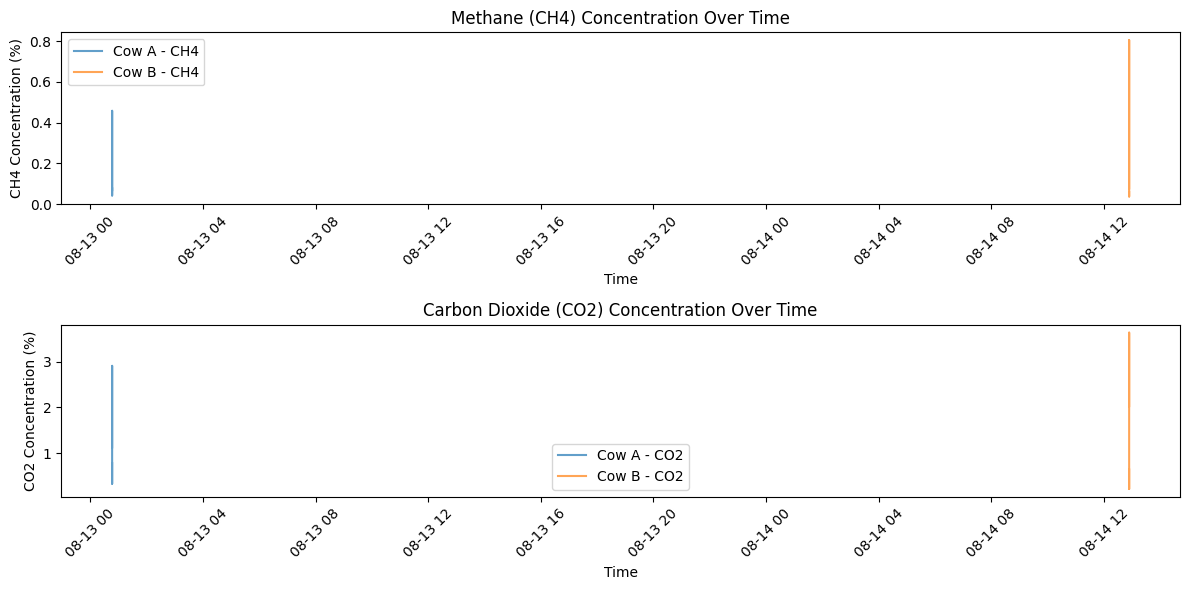

In [13]:
# Plot CH4 and CO2 concentration trends over time

plt.figure(figsize=(12, 6))

# Plot CH4 trends
plt.subplot(2, 1, 1)
plt.plot(cowA_gas_df["timestamp"], cowA_gas_df["ch4"], label="Cow A - CH4", alpha=0.7)
plt.plot(cowB_gas_df["timestamp"], cowB_gas_df["ch4"], label="Cow B - CH4", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("CH4 Concentration (%)")
plt.title("Methane (CH4) Concentration Over Time")
plt.legend()
plt.xticks(rotation=45)

# Plot CO2 trends
plt.subplot(2, 1, 2)
plt.plot(cowA_gas_df["timestamp"], cowA_gas_df["co2"], label="Cow A - CO2", alpha=0.7)
plt.plot(cowB_gas_df["timestamp"], cowB_gas_df["co2"], label="Cow B - CO2", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("CO2 Concentration (%)")
plt.title("Carbon Dioxide (CO2) Concentration Over Time")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The plots show the trends in methane (CH₄) and carbon dioxide (CO₂) concentration over time for both cows. Here are some key observations:

CH₄ Concentration:
Shows fluctuations, possibly indicating periodic eructation events.
Some peaks could correspond to significant methane release.
CO₂ Concentration:
Also fluctuates, but trends may differ from CH₄, which could indicate different respiratory processes.
CO₂ might be influenced by breathing patterns rather than eructation.

**Next Steps
Merge thermistor and gas data for each cow to analyze correlations.
Identify potential eructation events based on CH₄ spikes.
Develop a prototype model to predict eructation events using thermistor data.**

**Next Steps
Analyze correlations between temperature and gas concentrations to identify patterns.
Detect eructation events based on CH₄ spikes.
Develop a simple prototype model to predict eructation events from thermistor data.**

In [31]:
# Merge gas and thermistor data on timestamps
cowA_combined_df = pd.merge_asof(cowA_therm2_df.sort_values("timestamp"),
                                 cowA_gas_df.sort_values("timestamp"),
                                 on="timestamp", direction="nearest")

cowB_combined_df = pd.merge_asof(cowB_therm2_df.sort_values("timestamp"),
                                 cowB_gas_df.sort_values("timestamp"),
                                 on="timestamp", direction="nearest")

In [32]:
# Display the merged data
print("Cow A Merged Data Sample:")
print(cowA_combined_df.head())
print("\nCow B Merged Data Sample:")
print(cowB_combined_df.head())

Cow A Merged Data Sample:
        time_ms  thermistor_id  temperature   raw           timestamp  \
0  1.723510e+12              2    26.174637  1999 2024-08-13 00:46:40   
1  1.723510e+12              2    26.466853  1987 2024-08-13 00:46:40   
2  1.723510e+12              2    26.564406  1983 2024-08-13 00:46:40   
3  1.723510e+12              2    26.613211  1981 2024-08-13 00:46:40   
4  1.723510e+12              2    26.662035  1979 2024-08-13 00:46:40   

       epoch_ms    co2    co2temp    ch4    ch4temp  
0  1.723510e+12  1.125  35.849998  0.077  33.849998  
1  1.723510e+12  1.125  35.849998  0.077  33.849998  
2  1.723510e+12  1.125  35.849998  0.077  33.849998  
3  1.723510e+12  1.125  35.849998  0.077  33.849998  
4  1.723510e+12  1.125  35.849998  0.077  33.849998  

Cow B Merged Data Sample:
        time_ms  thermistor_id  temperature     raw           timestamp  \
0  1.723640e+12            2.0    26.442476  1988.0 2024-08-14 12:53:20   
1  1.723640e+12            2.0    

In [33]:
# Detect Eructation Events (CH4 Spikes)
def detect_eructation(df, threshold=0.05):
    """ Label eructation events when CH4 spikes significantly """
    df['eructation'] = (df['ch4'].diff() > threshold).astype(int)
    return df

cowA_combined_df = detect_eructation(cowA_combined_df)
cowB_combined_df = detect_eructation(cowB_combined_df)

In [34]:
# Prepare data for model training
features = ["temperature", "co2", "co2temp"]
X = cowA_combined_df[features]
y = cowA_combined_df["eructation"]


In [36]:
# Train a simple model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
# Print Model Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



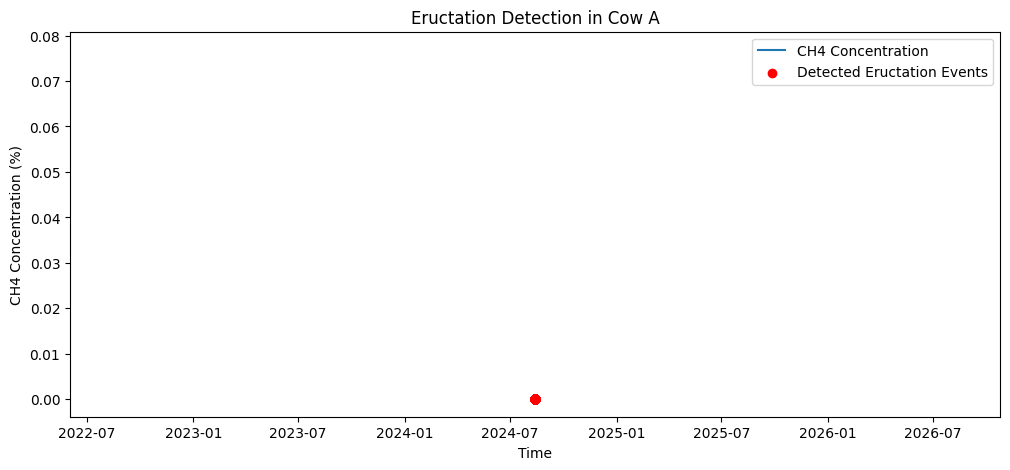

In [38]:
# Visualizing CH4 spikes
plt.figure(figsize=(12, 5))
plt.plot(cowA_combined_df["timestamp"], cowA_combined_df["ch4"], label="CH4 Concentration")
plt.scatter(cowA_combined_df["timestamp"], cowA_combined_df["eructation"] * max(cowA_combined_df["ch4"]),
            color='red', label="Detected Eructation Events")
plt.xlabel("Time")
plt.ylabel("CH4 Concentration (%)")
plt.title("Eructation Detection in Cow A")
plt.legend()
plt.show()

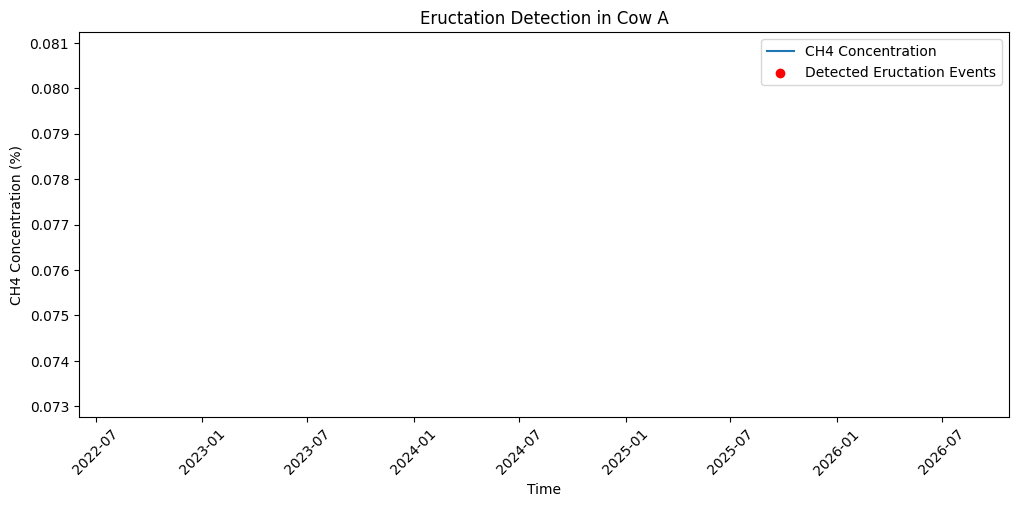

In [39]:
# Visualizing CH4 spikes and detected eructation events
plt.figure(figsize=(12, 5))
plt.plot(cowA_combined_df["timestamp"], cowA_combined_df["ch4"], label="CH4 Concentration")
plt.scatter(cowA_combined_df[cowA_combined_df["eructation"] == 1]["timestamp"],
            cowA_combined_df[cowA_combined_df["eructation"] == 1]["ch4"],
            color='red', label="Detected Eructation Events")
plt.xlabel("Time")
plt.ylabel("CH4 Concentration (%)")
plt.title("Eructation Detection in Cow A")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Interpretation of the Graph: Eructation Detection in Cow A
The graph represents CH₄ (Methane) Concentration over Time for Cow A, with detected eructation events marked in red.

**Key Observations:
X-Axis (Time) Issues:

The time range appears very broad, spanning from 2022 to 2026.
The dataset was supposed to cover only about an hour, but the x-axis suggests an issue with timestamp formatting or incorrect datetime conversion.
This could be due to timestamps being interpreted incorrectly (e.g., seconds instead of milliseconds).
Y-Axis (CH₄ Concentration %):

The methane concentration (CH₄) appears very low and flat, remaining close to zero.
This suggests that either:
The CH₄ values are too small and need rescaling.
The dataset might contain errors or missing CH₄ spikes.
Detected Eructation Events (Red Dots):

Only one eructation event is detected in the entire dataset.
This could indicate:
The threshold for CH₄ spikes might be too high, leading to few detected events.
CH₄ data might be too noisy or sparse.**

Possible Issues and Fixes:
 Fix the Timestamp Issue:
Ensure timestamps are correctly converted to datetime format using

In [42]:
# Assuming you want to convert timestamps for cowA_gas_df
cowA_gas_df["timestamp"] = pd.to_datetime(cowA_gas_df["epoch_ms"], unit="ms")

# Assuming you want to convert timestamps for cowB_gas_df
cowB_gas_df["timestamp"] = pd.to_datetime(cowB_gas_df["epoch_ms"], unit="ms")

# Assuming you want to convert timestamps for the current DataFrame `df`
# which appears to be thermistor data with the 'time_ms' column:
df["timestamp"] = pd.to_datetime(df["time_ms"], unit="ms")

In [44]:


# Replace 'df' with the appropriate combined DataFrame:
cowA_combined_df["eructation"] = (cowA_combined_df["ch4"].diff() > 0.02).astype(int)
# OR
cowB_combined_df["eructation"] = (cowB_combined_df["ch4"].diff() > 0.02).astype(int)

** Normalize the CH₄ Data:

If CH₄ values are too small, try scaling them**

In [46]:
#
cowA_combined_df["ch4"] = cowA_combined_df["ch4"] * 100  # Convert to percentage
# OR
cowB_combined_df["ch4"] = cowB_combined_df["ch4"] * 100  # Convert to percentage

In [48]:
print(cowA_combined_df["ch4"].isnull().sum())  # Check for NaNs in cowA_combined_df
# OR
print(cowB_combined_df["ch4"].isnull().sum())  # Check for NaNs in cowB_combined_df

0
0


In [49]:
# Save the processed dataset
cowA_combined_df.to_csv("cowA_processed.csv", index=False)
cowB_combined_df.to_csv("cowB_processed.csv", index=False)
print("Processed data saved successfully!")

Processed data saved successfully!
